In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install category_encoders

In [ ]:
!pip install feature-engine

In [103]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from category_encoders import HashingEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from feature_engine.encoding import CountFrequencyEncoder, MeanEncoder, RareLabelEncoder, OrdinalEncoder

In [104]:
data = pd.read_csv('https://github.com/limperstickhelp23/Credit_Fraud_Detection/blob/1e583fb73944ba26fdb040d3590a4672578c4676/DataSets/fraud_test.csv?raw=True', index_col=0)

In [105]:
y = data["is_fraud"]
X = data.drop(['is_fraud'],axis=1)

In [106]:
#Modify columns
X_used = X.drop(['Unnamed: 0','street','city','state','cc_num', 'unix_time', 'trans_num'], axis=1)
X_used[['date', 'time']] = X_used['trans_date_trans_time'].str.split(' ', expand=True)
X_used[['day', 'month', 'year']] = X_used['date'].str.split('/', expand=True)
X_used['time'] = X_used['time'].apply(lambda x: x.split(':')[0])
X_used['dob'] = X_used['dob'].apply(lambda x: x.split('/')[-1])
X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})
X_used = X_used.drop(['trans_date_trans_time','date'], axis=1)

<ipython-input-106-ee95265836cb>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})


In [ ]:
print(X_used)

In [107]:
used_data = X_used
used_data['is_fraud'] = y

In [ ]:
print(used_data)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(used_data.drop('is_fraud', axis = 1),
                                                    data['is_fraud'],
                                                    stratify = used_data['is_fraud'],
                                                    test_size = 0.5)

In [109]:
train_data = X_train
train_data['is_fraud'] = y_train

<ipython-input-110-69342c6395cb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=train_data, palette=colors)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

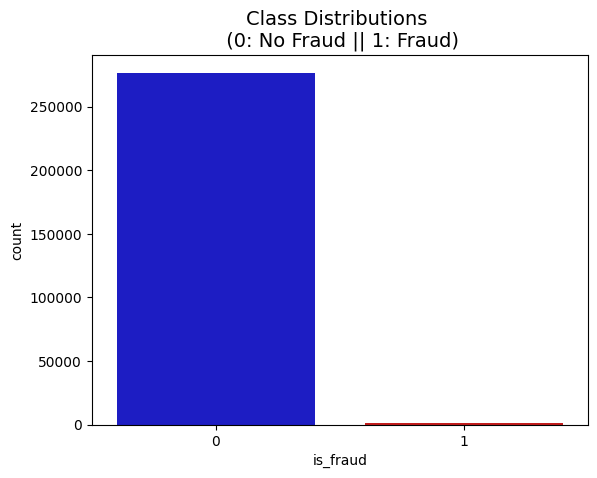

In [110]:
#Show plot
import matplotlib.pyplot as plt
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='is_fraud', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [111]:
features = used_data.select_dtypes(np.object_).columns
cat_features = []
for feature in features:
    used_data[feature] = used_data[feature].astype('category')
    cat_features.append(feature)

In [ ]:
print(used_data.dtypes)

In [113]:
target_encoder = TargetEncoder()
train_data[cat_features] = target_encoder.fit_transform(train_data[cat_features], train_data["is_fraud"])

In [ ]:
train_data.head()

In [114]:
X_test[cat_features] = target_encoder.transform(X_test[cat_features])

In [116]:
#Undersampling
def undersample(train_data):
  train_data = train_data.sample(frac=1)
  fraud_data = train_data.loc[train_data['is_fraud'] == 1]
  non_fraud_data = train_data.loc[train_data['is_fraud'] == 0][:1500]
  normal_distributed_data = pd.concat([fraud_data, non_fraud_data])
  new_data = normal_distributed_data.sample(frac=1, random_state=42)
  return new_data


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
#Run XGBoost
balanced_datas = []
best_predict = []
best_predict_proba = []
score = 0
for i in range(10):
  balanced_datas.append(undersample(train_data))

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(n_estimators=100,
                              max_depth=3,
                              learning_rate=0.1)

for data in balanced_datas:
  X_train = data.drop(columns=['is_fraud'])
  y_train = data['is_fraud']
  xgb_model.fit(X_train, y_train)
  y_pred_proba = xgb_model.predict_proba(X_test)
  y_pred = xgb_model.predict(X_test)
  roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  if(score<roc_auc):
    score = roc_auc
    best_predict = y_pred
    best_predict_proba = y_pred_proba



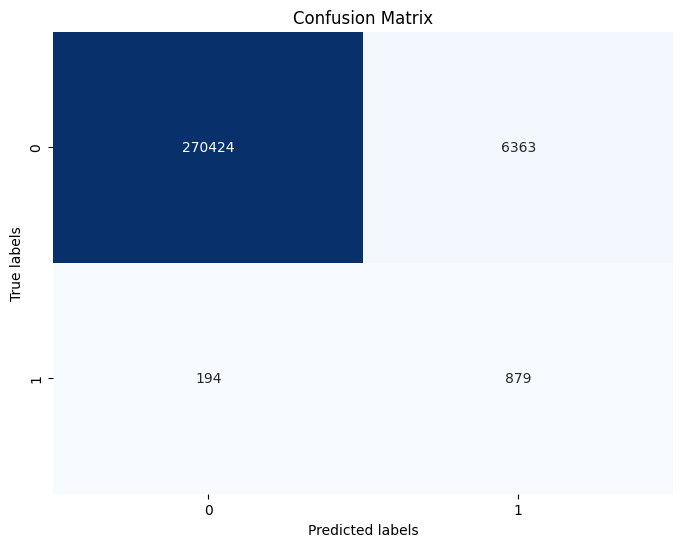

In [119]:
cm = confusion_matrix(y_test, best_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [120]:
print(f"roc_auc score: {score}")

roc_auc score: 0.9830010123725332


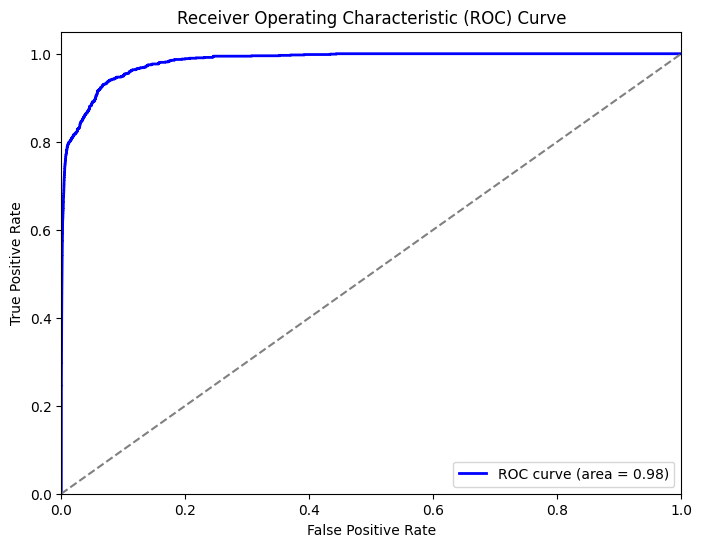

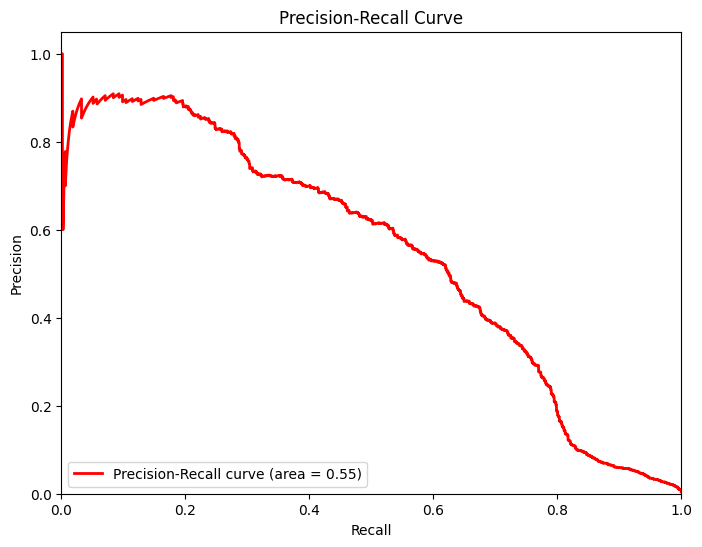

In [121]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:,1])
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()
